In [6]:
%%capture
!pip install stim

In [7]:
%%capture
!pip install sinter
!pip install pymatching

In [5]:
import stim
from math import exp

In [4]:
import sinter
import pymatching
import matplotlib.pyplot as plt

# Noise in quantum dots
Loss–DiVincenzo (LD) qubit

Singlet–triplet (ST) qubit

In [ ]:
ld = { 't2': 21e-6, 'tq': 40e-9, 'tr': 24e-6, 'p1': 4e-4, 'p2': 2e-3, 'pr': 2.4e-3, 'pp': 6.5e-3 }
st = { 't2': 14.8e-6, 'tq': 40e-9, 'tr': 2.4e-6, 'p1': 4e-3, 'p2': 4e-3, 'pr': 4e-4, 'pp': 4e-3 }
#gu = { 't2': 21e-6, 'tq': 6.5e-3, 'tr': 6.5e-3, 'p1': 4e-3, 'p2': 4e-3, 'pr': 4e-4, 'pp': 4e-3 }
pi = lambda t, t2: .5 * ( 1 - exp(-t*t/t2/t2) )

# Unrotated surface code

In [ ]:
# @title
def v(k, D, q):
    i = k // D
    j = k % D
    n, w, e, s = k-D, k-1, k+1, k+D
    d = ''
    if i > 0: d += f'rec[-{len(q) - q.index(n)}] '
    if j > 0: d += f'rec[-{len(q) - q.index(w)}] '
    if j < D-1: d += f'rec[-{len(q) - q.index(e)}] '
    if i < D-1: d += f'rec[-{len(q) - q.index(s)}] '
    return d

def sc(d, rnd=1, nm=None):
    D = 2 * d - 1
    q = [D*i+j for i in range(D) for j in range(D) if (i + j) % 2 == 0]
    # stabs
    x = [D*i+j for i in range(D) for j in range(D) if i % 2 == 0 and j % 2 == 1]
    z = [D*i+j for i in range(D) for j in range(D) if i % 2 == 1 and j % 2 == 0]
    # cnots
    xe = [s + o for s in x for o in (0, 1)]
    xw = [s - o for s in x for o in (0, 1)]
    xs = [s + o for s in x for o in (0, D) if s < D*D-D]
    xn = [s - o for s in x for o in (0, D) if s >= D]
    ze = [s + o for s in z for o in (1, 0) if s % D < D-1]
    zw = [s - o for s in z for o in (1, 0) if s % D > 0]
    zs = [s + o for s in z for o in (D, 0)]
    zn = [s - o for s in z for o in (D, 0)]
    # idle
    if nm: pq = pi(nm["tq"], nm["t2"])
    if nm: pr = pi(nm["tr"], nm["t2"])
    # round
    r = ['H ' + ' '.join(map(str, x))]
    if nm: r.append(f'Y_ERROR({nm["p1"]}) ' + ' '.join(map(str, x)))
    r.append('TICK')
    if nm: r.append(f'PAULI_CHANNEL_1({0}, {0}, {pq}) ' + ' '.join(map(str, [i*D if i%2==0 else i*D+D-1 for i in range(D)])))
    r.append('TICK')
    r.append('CX ' + ' '.join(map(str, xe)))
    if nm: r.append(f'DEPOLARIZE2({nm["p2"]}) ' + ' '.join(map(str, xe)))
    r.append('CX ' + ' '.join(map(str, ze)))
    if nm: r.append(f'DEPOLARIZE2({nm["p2"]}) ' + ' '.join(map(str, ze)))
    r.append('TICK')
    if nm: r.append(f'PAULI_CHANNEL_1({0}, {0}, {pq}) ' + ' '.join(map(str, [j if j%2==0 else D*D-D+j for j in range(D)])))
    r.append('TICK')
    r.append('CX ' + ' '.join(map(str, xs)))
    if nm: r.append(f'DEPOLARIZE2({nm["p2"]}) ' + ' '.join(map(str, xs)))
    r.append('CX ' + ' '.join(map(str, zs)))
    if nm: r.append(f'DEPOLARIZE2({nm["p2"]}) ' + ' '.join(map(str, zs)))
    r.append('TICK')
    if nm: r.append(f'PAULI_CHANNEL_1({0}, {0}, {pq}) ' + ' '.join(map(str, [j if j%2==1 else D*D-D+j for j in range(D)])))
    r.append('TICK')
    r.append('CX ' + ' '.join(map(str, xn)))
    if nm: r.append(f'DEPOLARIZE2({nm["p2"]}) ' + ' '.join(map(str, xn)))
    r.append('CX ' + ' '.join(map(str, zn)))
    if nm: r.append(f'DEPOLARIZE2({nm["p2"]}) ' + ' '.join(map(str, zn)))
    r.append('TICK')
    if nm: r.append(f'PAULI_CHANNEL_1({0}, {0}, {pq}) ' + ' '.join(map(str, [i*D if i%2==1 else i*D+D-1 for i in range(D)])))
    r.append('TICK')
    r.append('CX ' + ' '.join(map(str, xw)))
    if nm: r.append(f'DEPOLARIZE2({nm["p2"]}) ' + ' '.join(map(str, xw)))
    r.append('CX ' + ' '.join(map(str, zw)))
    if nm: r.append(f'DEPOLARIZE2({nm["p2"]}) ' + ' '.join(map(str, zw)))
    r.append('TICK')
    r.append('H ' + ' '.join(map(str, x)))
    if nm: r.append(f'Y_ERROR({nm["p1"]}) ' + ' '.join(map(str, x)))
    r.append('TICK')
    if nm: r.append(f'PAULI_CHANNEL_1({0}, {0}, {pr}) ' + ' '.join(map(str, q)))
    r.append('TICK')
    if nm: r.append(f'X_ERROR({nm["pr"]}) ' + ' '.join(map(str, x+z)))
    r.append(f'MR ' + ' '.join(map(str, x+z)))
    if nm: r.append(f'X_ERROR({nm["pp"]}) ' + ' '.join(map(str, x+z)))
    # circ
    c = [f'QUBIT_COORDS({j}, {i}) {D*i+j}' for i in range(D) for j in range(D)]
    c.append('R ' + ' '.join(map(str, range(D*D))))
    if nm: c.append(f'X_ERROR({nm["pp"]}) ' + ' '.join(map(str, range(D*D))))
    c.append('TICK')
    c.extend(r)
    c.extend([f'DETECTOR({k%D}, {k//D}, 0) rec[-{len(z)-i}]' for i, k in enumerate(z)])
    c.append('TICK')
    if rnd > 1:
        c.append(f'REPEAT {rnd-1} {{')
        c.extend(r)
        c.append('SHIFT_COORDS(0, 0, 1)')
        c.extend([f'DETECTOR({k%D}, {k//D}, 0) rec[-{len(x+z)-i}] rec[-{2*len(x+z)-i}]' for i, k in enumerate(x+z)])
        c.append('TICK')
        c.append('}')
    if nm: c.append(f'PAULI_CHANNEL_1({0}, {0}, {pr}) ' + ' '.join(map(str, x+z)))
    c.append('TICK')
    if nm: c.append(f'X_ERROR({nm["pr"]}) ' + ' '.join(map(str, q)))
    c.append(f'M ' + ' '.join(map(str, q)))
    c.extend([f'DETECTOR({k%D}, {k//D}, 1) ' + v(k, D, q) + f'rec[-{len(q)+len(z)-i}]' for i, k in enumerate(z)])
    c.append(f'OBSERVABLE_INCLUDE(0) ' + ' '.join([f'rec[-{len(q)-i}]' for i in range(d)]))
    return stim.Circuit('\n'.join(c))

In [ ]:
sh = {
    (d,r): sc(d, r, st)
    for d in [3,5,7,9]
    for r in range(2, 19, 2)
}

In [ ]:
tasks = [
    sinter.Task(
        circuit=sh[(d, r)],
        json_metadata={'d': d, 'r': r},
    )
    for d in [3,5,7,9]
    for r in range(2, 19, 2)
]

stats = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=1_000
)

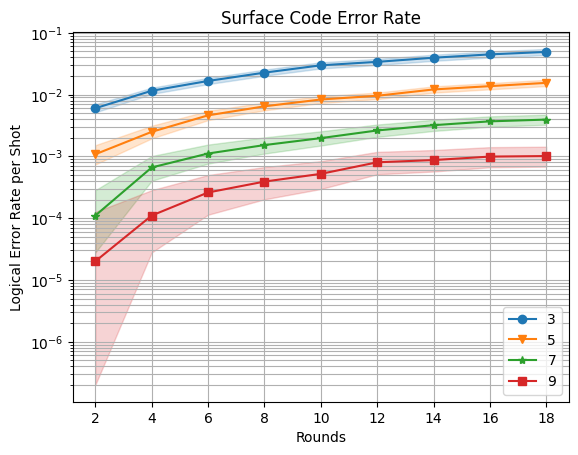

In [ ]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=stats,
    x_func=lambda stats: stats.json_metadata['r'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_yscale("log")
ax.set_title("Surface Code Error Rate")
ax.set_xlabel("Rounds")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend();

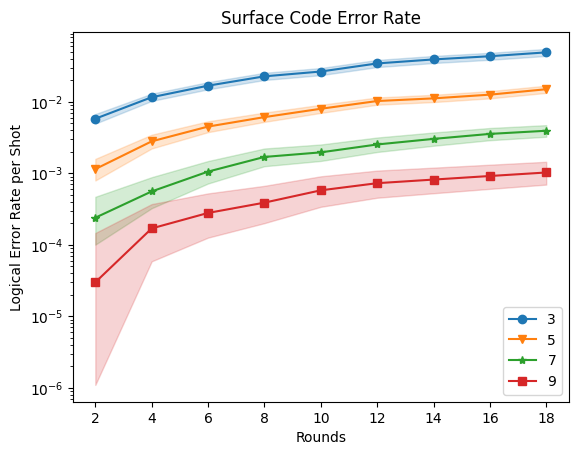

In [ ]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=stats,
    x_func=lambda stats: stats.json_metadata['r'],
    group_func=lambda stats: stats.json_metadata['d'],
)
#ax.set_ylim(1e-4, 1e-0)
#ax.set_xlim(5e-2, 5e-1)
#ax.loglog()
ax.set_yscale("log")
ax.set_title("Surface Code Error Rate")
ax.set_xlabel("Rounds")
ax.set_ylabel("Logical Error Rate per Shot")
#ax.grid(which='major')
#ax.grid(which='minor')
ax.legend();
#fig.set_dpi(120)

In [ ]:
c = stim.Circuit.generated(
    "surface_code:unrotated_memory_z",
    rounds=3,
    distance=5
)
c

stim.Circuit('''
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 0) 3
    QUBIT_COORDS(4, 0) 4
    QUBIT_COORDS(5, 0) 5
    QUBIT_COORDS(6, 0) 6
    QUBIT_COORDS(7, 0) 7
    QUBIT_COORDS(8, 0) 8
    QUBIT_COORDS(0, 1) 9
    QUBIT_COORDS(1, 1) 10
    QUBIT_COORDS(2, 1) 11
    QUBIT_COORDS(3, 1) 12
    QUBIT_COORDS(4, 1) 13
    QUBIT_COORDS(5, 1) 14
    QUBIT_COORDS(6, 1) 15
    QUBIT_COORDS(7, 1) 16
    QUBIT_COORDS(8, 1) 17
    QUBIT_COORDS(0, 2) 18
    QUBIT_COORDS(1, 2) 19
    QUBIT_COORDS(2, 2) 20
    QUBIT_COORDS(3, 2) 21
    QUBIT_COORDS(4, 2) 22
    QUBIT_COORDS(5, 2) 23
    QUBIT_COORDS(6, 2) 24
    QUBIT_COORDS(7, 2) 25
    QUBIT_COORDS(8, 2) 26
    QUBIT_COORDS(0, 3) 27
    QUBIT_COORDS(1, 3) 28
    QUBIT_COORDS(2, 3) 29
    QUBIT_COORDS(3, 3) 30
    QUBIT_COORDS(4, 3) 31
    QUBIT_COORDS(5, 3) 32
    QUBIT_COORDS(6, 3) 33
    QUBIT_COORDS(7, 3) 34
    QUBIT_COORDS(8, 3) 35
    QUBIT_COORDS(0, 4) 36
    QUBIT_COORDS(1, 4) 37
    Q

In [ ]:
for op in c:
    print(op.gate_args_copy())

[0.0, 0.0]
[1.0, 0.0]
[2.0, 0.0]
[3.0, 0.0]
[4.0, 0.0]
[5.0, 0.0]
[6.0, 0.0]
[7.0, 0.0]
[8.0, 0.0]
[0.0, 1.0]
[1.0, 1.0]
[2.0, 1.0]
[3.0, 1.0]
[4.0, 1.0]
[5.0, 1.0]
[6.0, 1.0]
[7.0, 1.0]
[8.0, 1.0]
[0.0, 2.0]
[1.0, 2.0]
[2.0, 2.0]
[3.0, 2.0]
[4.0, 2.0]
[5.0, 2.0]
[6.0, 2.0]
[7.0, 2.0]
[8.0, 2.0]
[0.0, 3.0]
[1.0, 3.0]
[2.0, 3.0]
[3.0, 3.0]
[4.0, 3.0]
[5.0, 3.0]
[6.0, 3.0]
[7.0, 3.0]
[8.0, 3.0]
[0.0, 4.0]
[1.0, 4.0]
[2.0, 4.0]
[3.0, 4.0]
[4.0, 4.0]
[5.0, 4.0]
[6.0, 4.0]
[7.0, 4.0]
[8.0, 4.0]
[0.0, 5.0]
[1.0, 5.0]
[2.0, 5.0]
[3.0, 5.0]
[4.0, 5.0]
[5.0, 5.0]
[6.0, 5.0]
[7.0, 5.0]
[8.0, 5.0]
[0.0, 6.0]
[1.0, 6.0]
[2.0, 6.0]
[3.0, 6.0]
[4.0, 6.0]
[5.0, 6.0]
[6.0, 6.0]
[7.0, 6.0]
[8.0, 6.0]
[0.0, 7.0]
[1.0, 7.0]
[2.0, 7.0]
[3.0, 7.0]
[4.0, 7.0]
[5.0, 7.0]
[6.0, 7.0]
[7.0, 7.0]
[8.0, 7.0]
[0.0, 8.0]
[1.0, 8.0]
[2.0, 8.0]
[3.0, 8.0]
[4.0, 8.0]
[5.0, 8.0]
[6.0, 8.0]
[7.0, 8.0]
[8.0, 8.0]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.0, 1.0, 0.0]
[0.0, 3.0, 0.0]
[0.0, 5.0, 0.0]
[0.0, 7.0, 0.0]


AttributeError: 'stim._stim_sse2.CircuitRepeatBlock' object has no attribute 'gate_args_copy'

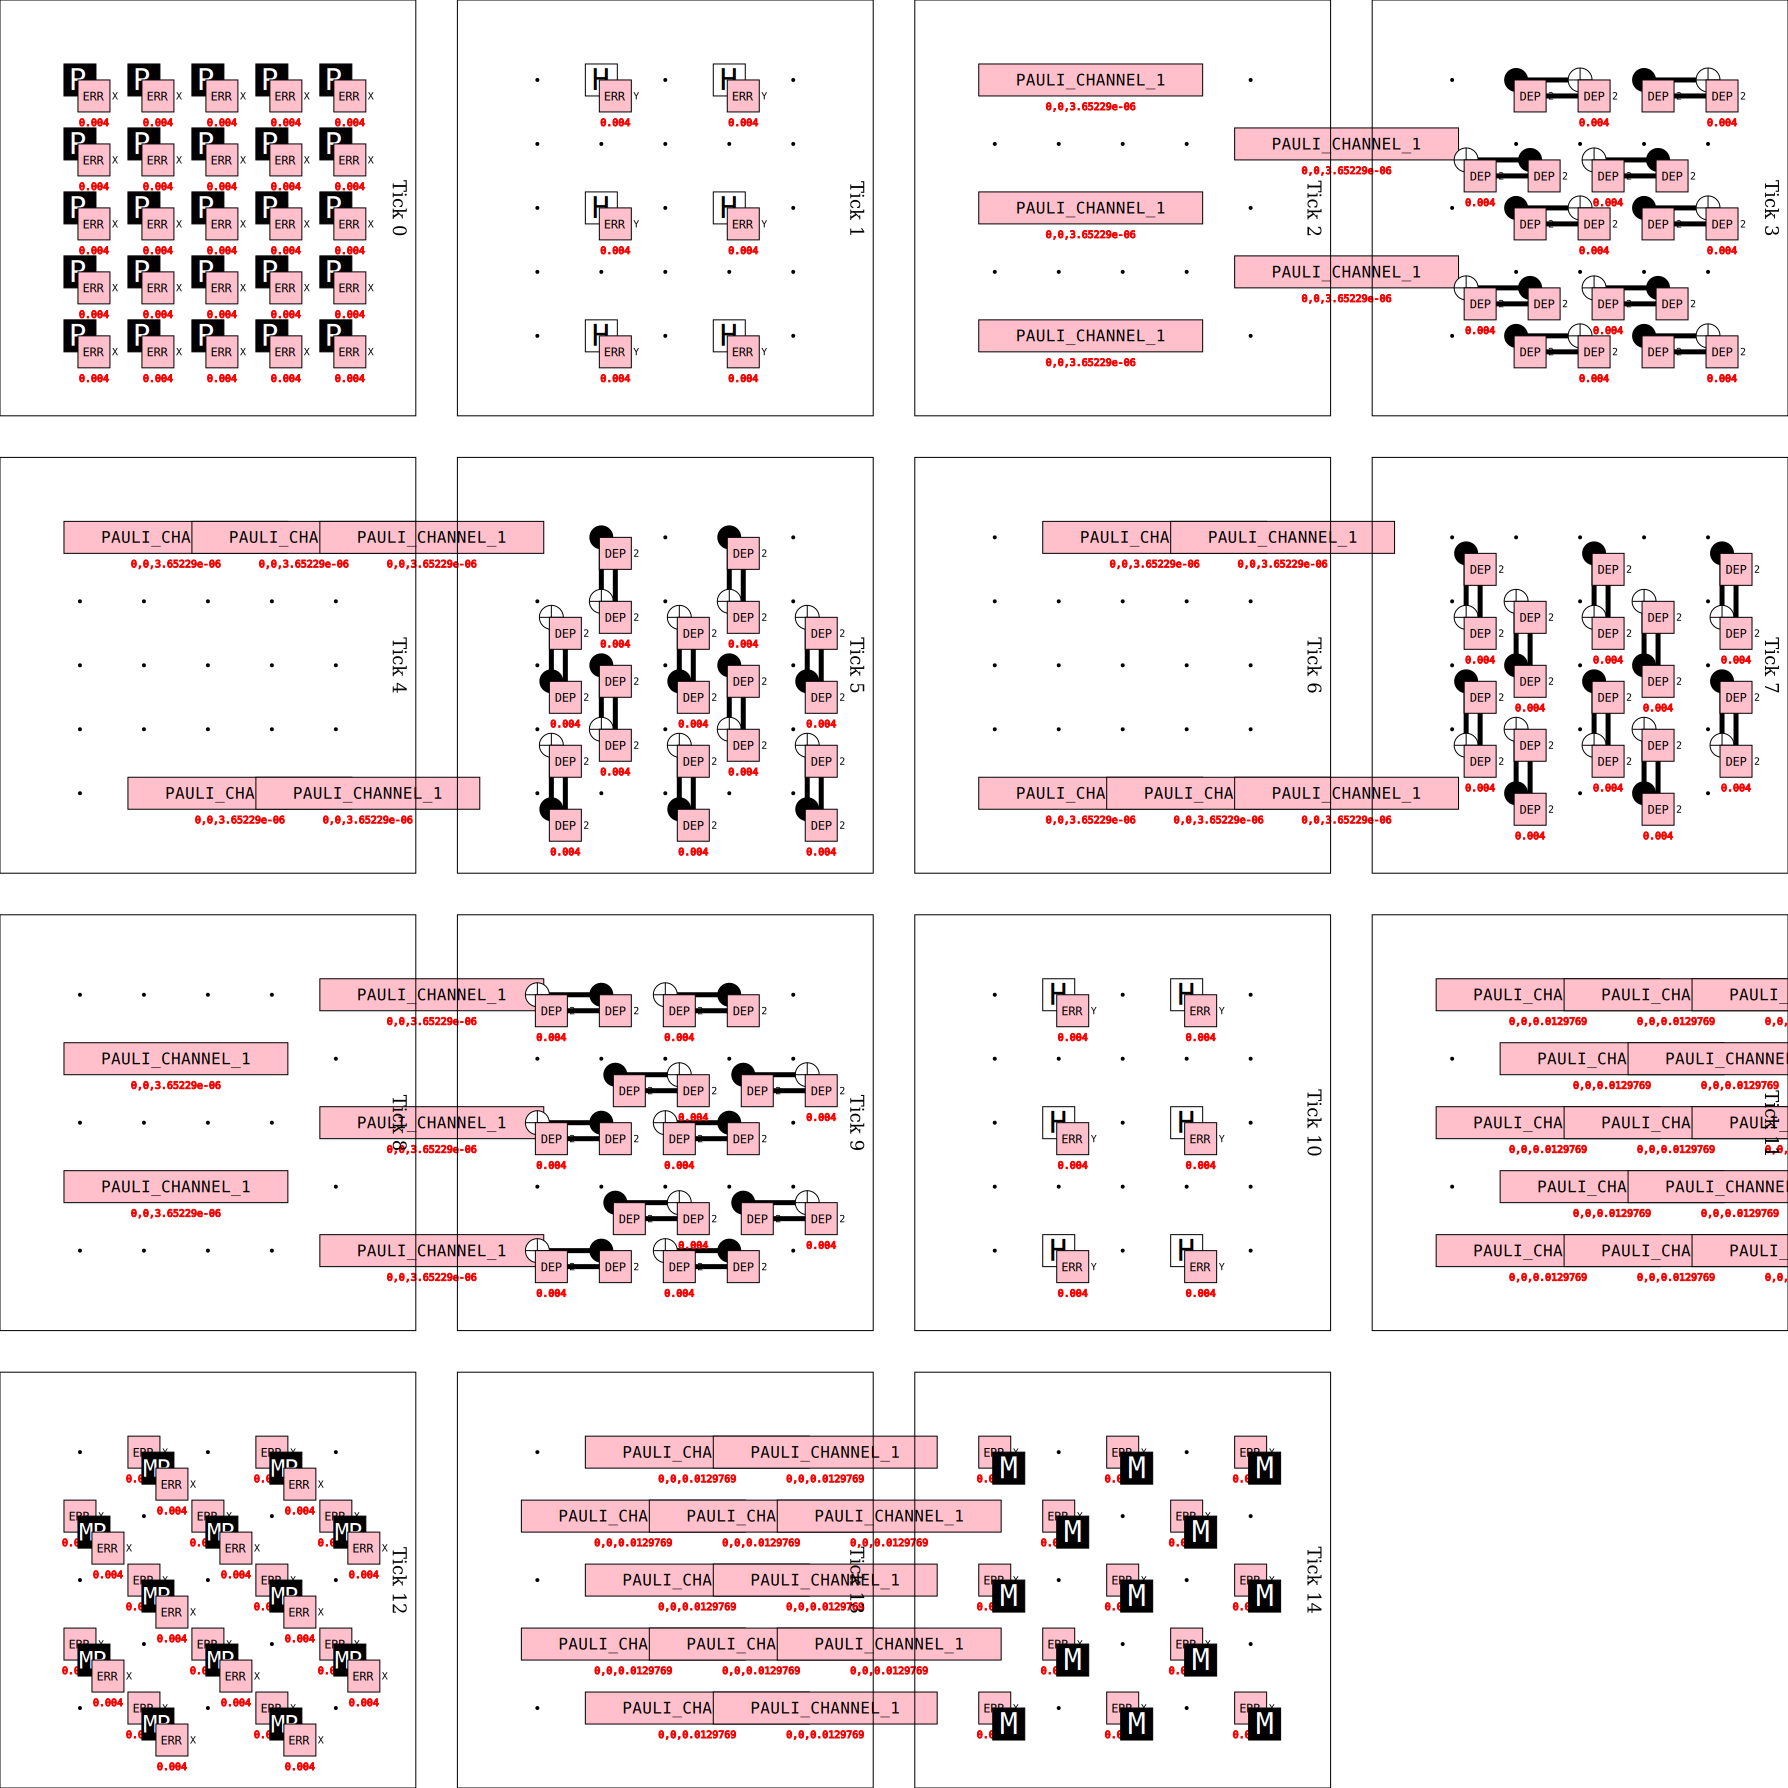

In [ ]:
#c.diagram()
c.diagram('timeslice-svg')
#with open('c.html', 'w') as f:
#c.diagram('interactive')
#c.to_crumble_url()
#c.without_noise().diagram('timeslice-svg')
#c.diagram('timeline-svg')
#c.diagram('timeline-3d')
#c.diagram("detslice-svg")

In [ ]:
dem = c[:-1].detector_error_model()
dem

stim.DetectorErrorModel('''
    detector(0, 1, 0) D0
    detector(2, 1, 0) D1
    detector(4, 1, 0) D2
    detector(6, 1, 0) D3
    detector(8, 1, 0) D4
    detector(0, 3, 0) D5
    detector(2, 3, 0) D6
    detector(4, 3, 0) D7
    detector(6, 3, 0) D8
    detector(8, 3, 0) D9
    detector(0, 5, 0) D10
    detector(2, 5, 0) D11
    detector(4, 5, 0) D12
    detector(6, 5, 0) D13
    detector(8, 5, 0) D14
    detector(0, 7, 0) D15
    detector(2, 7, 0) D16
    detector(4, 7, 0) D17
    detector(6, 7, 0) D18
    detector(8, 7, 0) D19
    detector(0, 1, 1) D20
    detector(2, 1, 1) D21
    detector(4, 1, 1) D22
    detector(6, 1, 1) D23
    detector(8, 1, 1) D24
    detector(0, 3, 1) D25
    detector(2, 3, 1) D26
    detector(4, 3, 1) D27
    detector(6, 3, 1) D28
    detector(8, 3, 1) D29
    detector(0, 5, 1) D30
    detector(2, 5, 1) D31
    detector(4, 5, 1) D32
    detector(6, 5, 1) D33
    detector(8, 5, 1) D34
    detector(0, 7, 1) D35
    detector(2, 7, 1) D36
    detector(4, 7, 1

# Bacon-Shor

# Phenomenological noise

In [ ]:
sc = stim.Circuit.generated(
    "surface_code:unrotated_memory_z",
    rounds=3,
    distance=3,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.04
)
sc

stim.Circuit('''
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 0) 3
    QUBIT_COORDS(4, 0) 4
    QUBIT_COORDS(0, 1) 5
    QUBIT_COORDS(1, 1) 6
    QUBIT_COORDS(2, 1) 7
    QUBIT_COORDS(3, 1) 8
    QUBIT_COORDS(4, 1) 9
    QUBIT_COORDS(0, 2) 10
    QUBIT_COORDS(1, 2) 11
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(3, 2) 13
    QUBIT_COORDS(4, 2) 14
    QUBIT_COORDS(0, 3) 15
    QUBIT_COORDS(1, 3) 16
    QUBIT_COORDS(2, 3) 17
    QUBIT_COORDS(3, 3) 18
    QUBIT_COORDS(4, 3) 19
    QUBIT_COORDS(0, 4) 20
    QUBIT_COORDS(1, 4) 21
    QUBIT_COORDS(2, 4) 22
    QUBIT_COORDS(3, 4) 23
    QUBIT_COORDS(4, 4) 24
    R 0 2 4 6 8 10 12 14 16 18 20 22 24 1 3 5 7 9 11 13 15 17 19 21 23
    TICK
    DEPOLARIZE1(0.04) 0 2 4 6 8 10 12 14 16 18 20 22 24
    H 1 3 11 13 21 23
    TICK
    CX 1 2 11 12 21 22 3 4 13 14 23 24 6 5 16 15 8 7 18 17
    TICK
    CX 1 6 11 16 3 8 13 18 10 5 20 15 12 7 22 17 14 9 24 19
    TICK
    CX 11 6 21 16 13 8 23 18 0 5 10 15 

In [ ]:
dem = sc.detector_error_model()
dem

stim.DetectorErrorModel('''
    error(0.0266667) D0 D1
    error(0.0266667) D0 D2
    error(0.01) D0 D8
    error(0.0266667) D0 L0
    error(0.0266667) D1
    error(0.0266667) D1 D3
    error(0.01) D1 D13
    error(0.0266667) D2 D3
    error(0.0266667) D2 D4
    error(0.01) D2 D9
    error(0.0266667) D2 L0
    error(0.0266667) D3
    error(0.0266667) D3 D5
    error(0.01) D3 D14
    error(0.0266667) D4 D5
    error(0.01) D4 D10
    error(0.0266667) D4 L0
    error(0.0266667) D5
    error(0.01) D5 D15
    error(0.0232457) D6
    error(0.013516) D6 D7
    error(0.013516) D6 D7 D9 L0
    error(0.013516) D6 D8 D9 D11
    error(0.013516) D6 D8 L0
    error(0.013516) D6 D11
    error(0.01) D6 D18
    error(0.0232457) D7
    error(0.013516) D7 D9 D10 D12
    error(0.013516) D7 D10 L0
    error(0.013516) D7 D12
    error(0.01) D7 D19
    error(0.013516) D8 D9
    error(0.013516) D8 D11 D13
    error(0.013516) D8 D13
    error(0.01) D8 D20
    error(0.013516) D8 L0
    error(0.013516) D9 D10
  

# Circuit level noise

In [ ]:
c3 = stim.Circuit.generated(
    "surface_code:unrotated_memory_z",
    rounds=3,
    distance=3,
    after_clifford_depolarization=0.004,
    after_reset_flip_probability=0.003,
    before_measure_flip_probability=0.002,
    before_round_data_depolarization=0.001
)
c3

stim.Circuit('''
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 0) 3
    QUBIT_COORDS(4, 0) 4
    QUBIT_COORDS(0, 1) 5
    QUBIT_COORDS(1, 1) 6
    QUBIT_COORDS(2, 1) 7
    QUBIT_COORDS(3, 1) 8
    QUBIT_COORDS(4, 1) 9
    QUBIT_COORDS(0, 2) 10
    QUBIT_COORDS(1, 2) 11
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(3, 2) 13
    QUBIT_COORDS(4, 2) 14
    QUBIT_COORDS(0, 3) 15
    QUBIT_COORDS(1, 3) 16
    QUBIT_COORDS(2, 3) 17
    QUBIT_COORDS(3, 3) 18
    QUBIT_COORDS(4, 3) 19
    QUBIT_COORDS(0, 4) 20
    QUBIT_COORDS(1, 4) 21
    QUBIT_COORDS(2, 4) 22
    QUBIT_COORDS(3, 4) 23
    QUBIT_COORDS(4, 4) 24
    R 0 2 4 6 8 10 12 14 16 18 20 22 24
    X_ERROR(0.003) 0 2 4 6 8 10 12 14 16 18 20 22 24
    R 1 3 5 7 9 11 13 15 17 19 21 23
    X_ERROR(0.003) 1 3 5 7 9 11 13 15 17 19 21 23
    TICK
    DEPOLARIZE1(0.001) 0 2 4 6 8 10 12 14 16 18 20 22 24
    H 1 3 11 13 21 23
    DEPOLARIZE1(0.004) 1 3 11 13 21 23
    TICK
    CX 1 2 11 12 21 22 3 4 

In [ ]:
tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=r,
            distance=d,
            after_clifford_depolarization=0.004,
            after_reset_flip_probability=0.003,
            before_measure_flip_probability=0.002,
            before_round_data_depolarization=0.001
        ),
        json_metadata={'d': d, 'r': r},
    )
    for d in [3,5,7,9]
    for r in range(1, 20, 2)
]

stats = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=10_000,
    max_errors=1_000
)

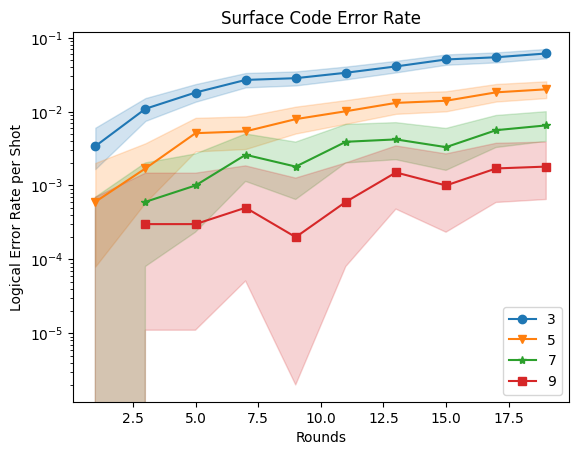

In [ ]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=stats,
    x_func=lambda stats: stats.json_metadata['r'],
    group_func=lambda stats: stats.json_metadata['d'],
)
#ax.set_ylim(1e-4, 1e-0)
#ax.set_xlim(5e-2, 5e-1)
#ax.loglog()
ax.set_yscale("log")
ax.set_title("Surface Code Error Rate")
ax.set_xlabel("Rounds")
ax.set_ylabel("Logical Error Rate per Shot")
#ax.grid(which='major')
#ax.grid(which='minor')
ax.legend();
#fig.set_dpi(120)

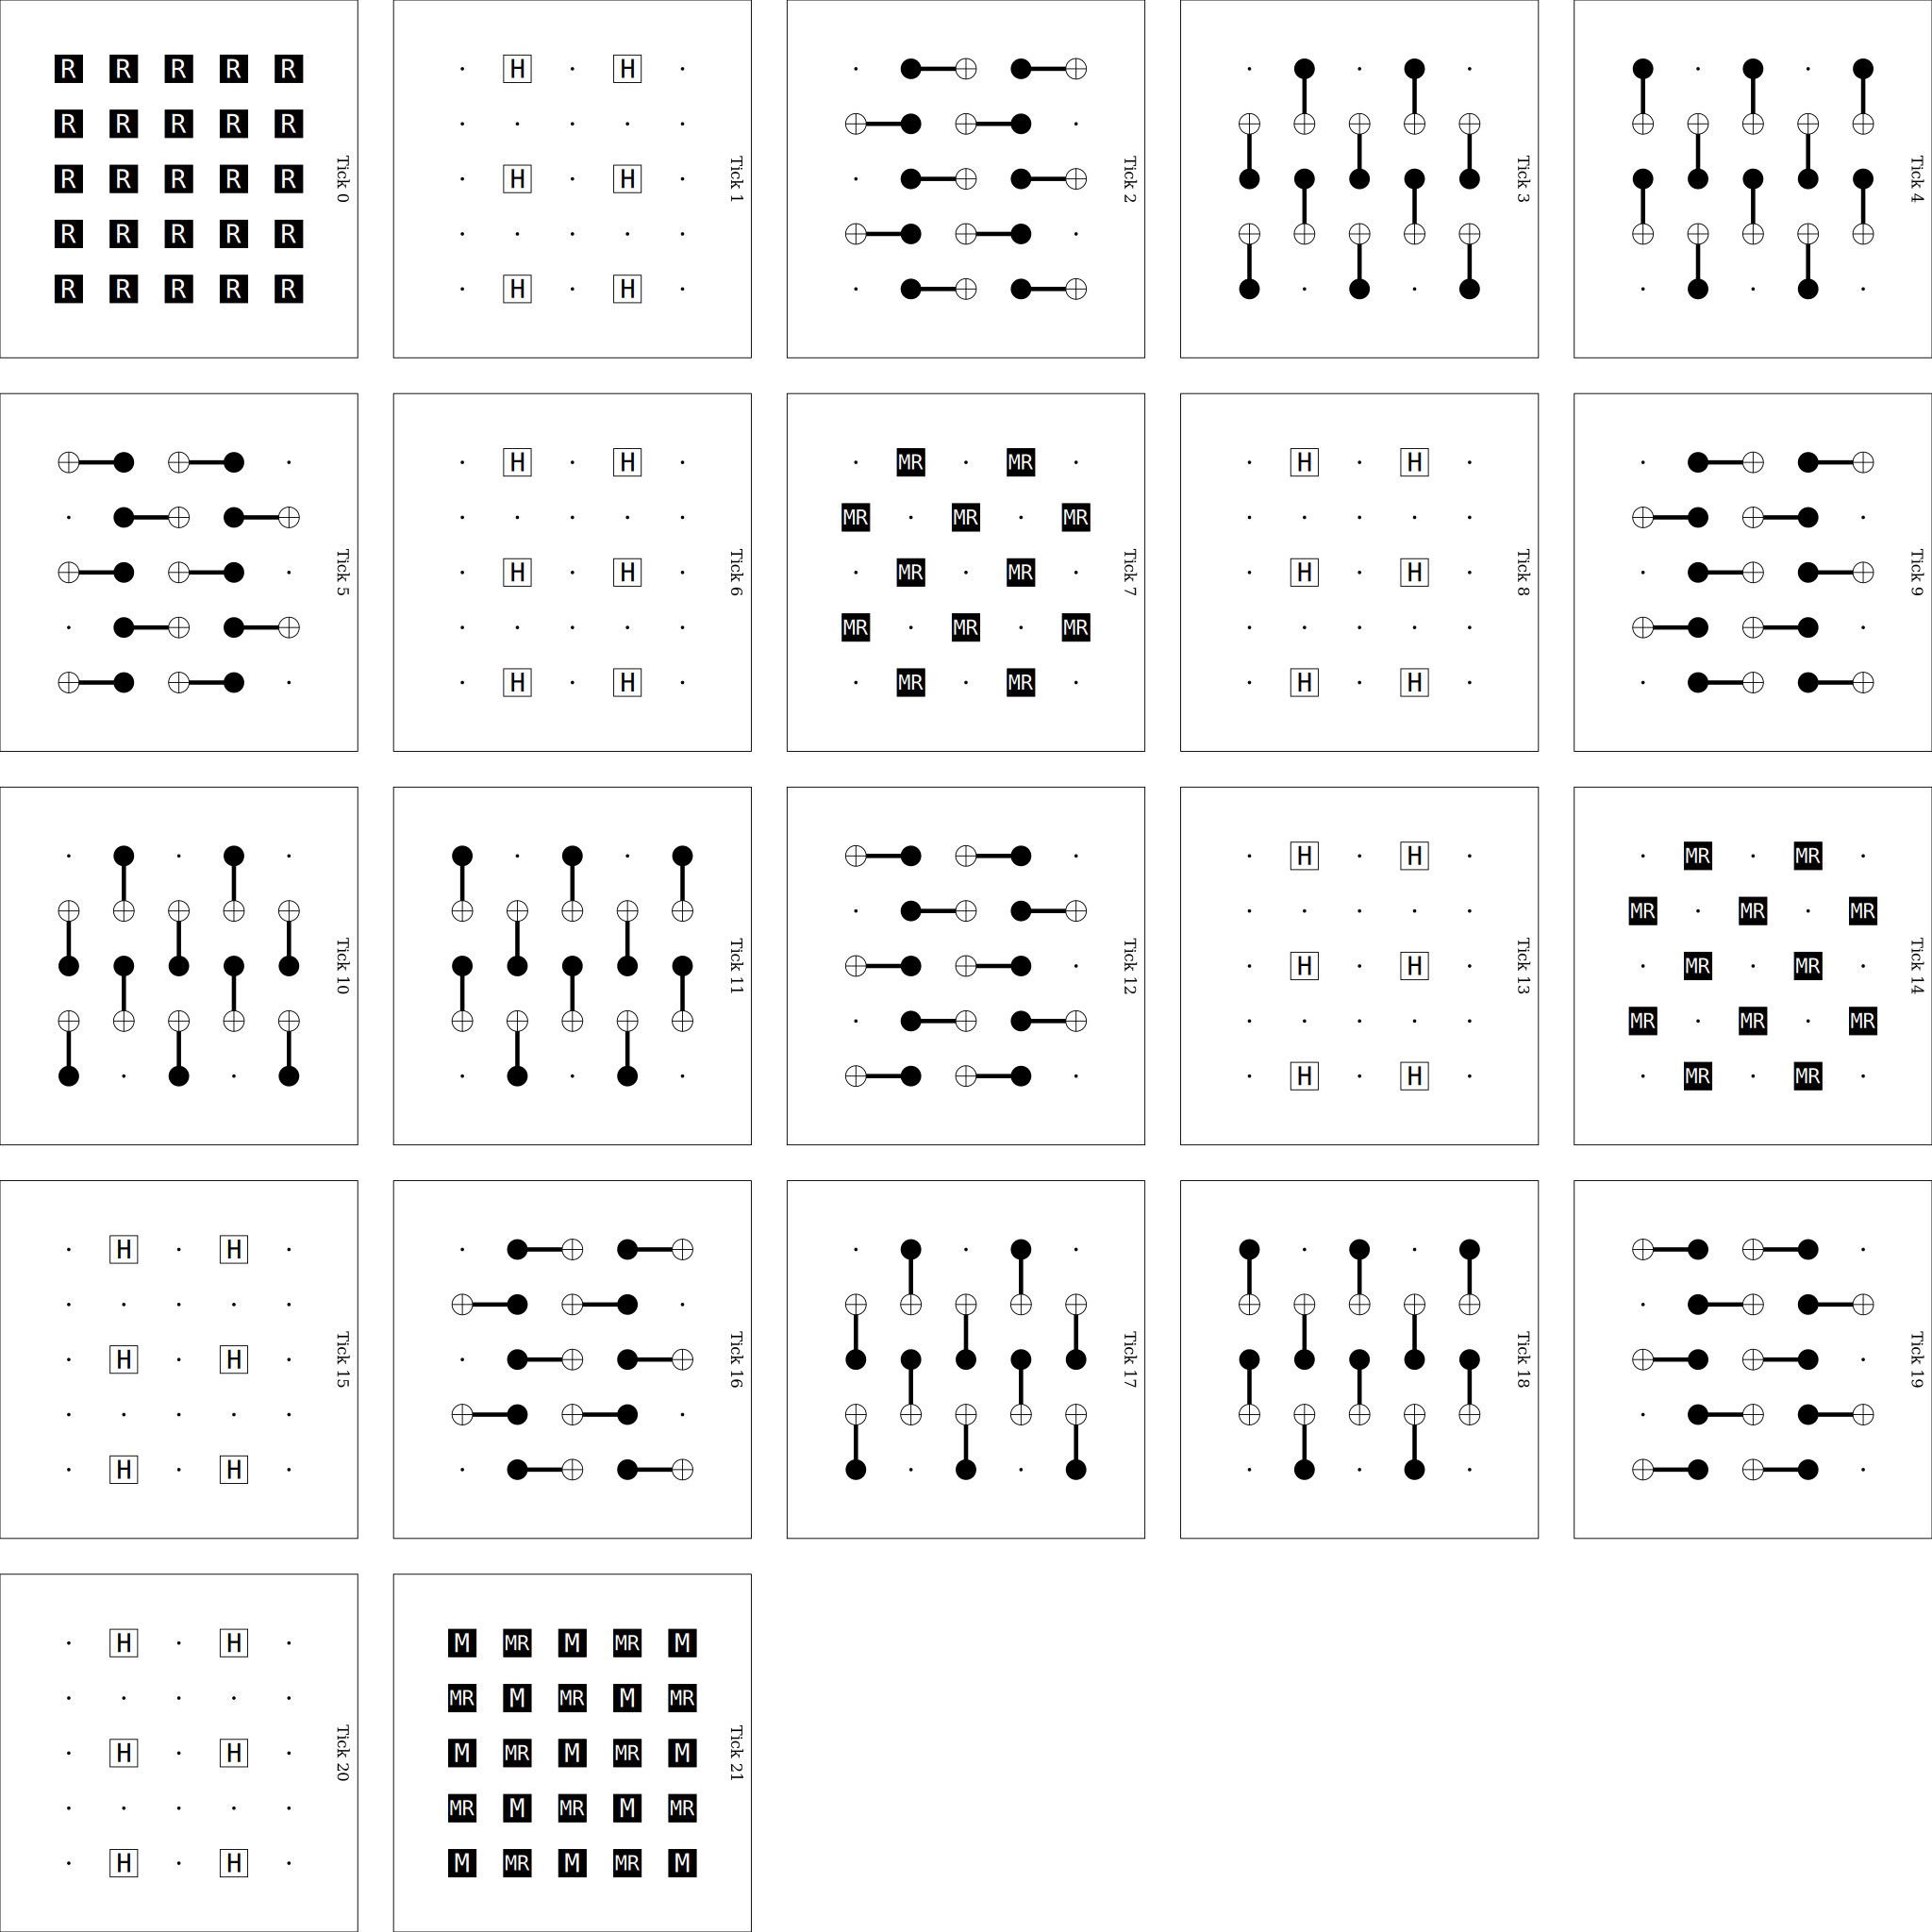

In [ ]:
sc.without_noise().diagram("timeslice-svg")

# Test

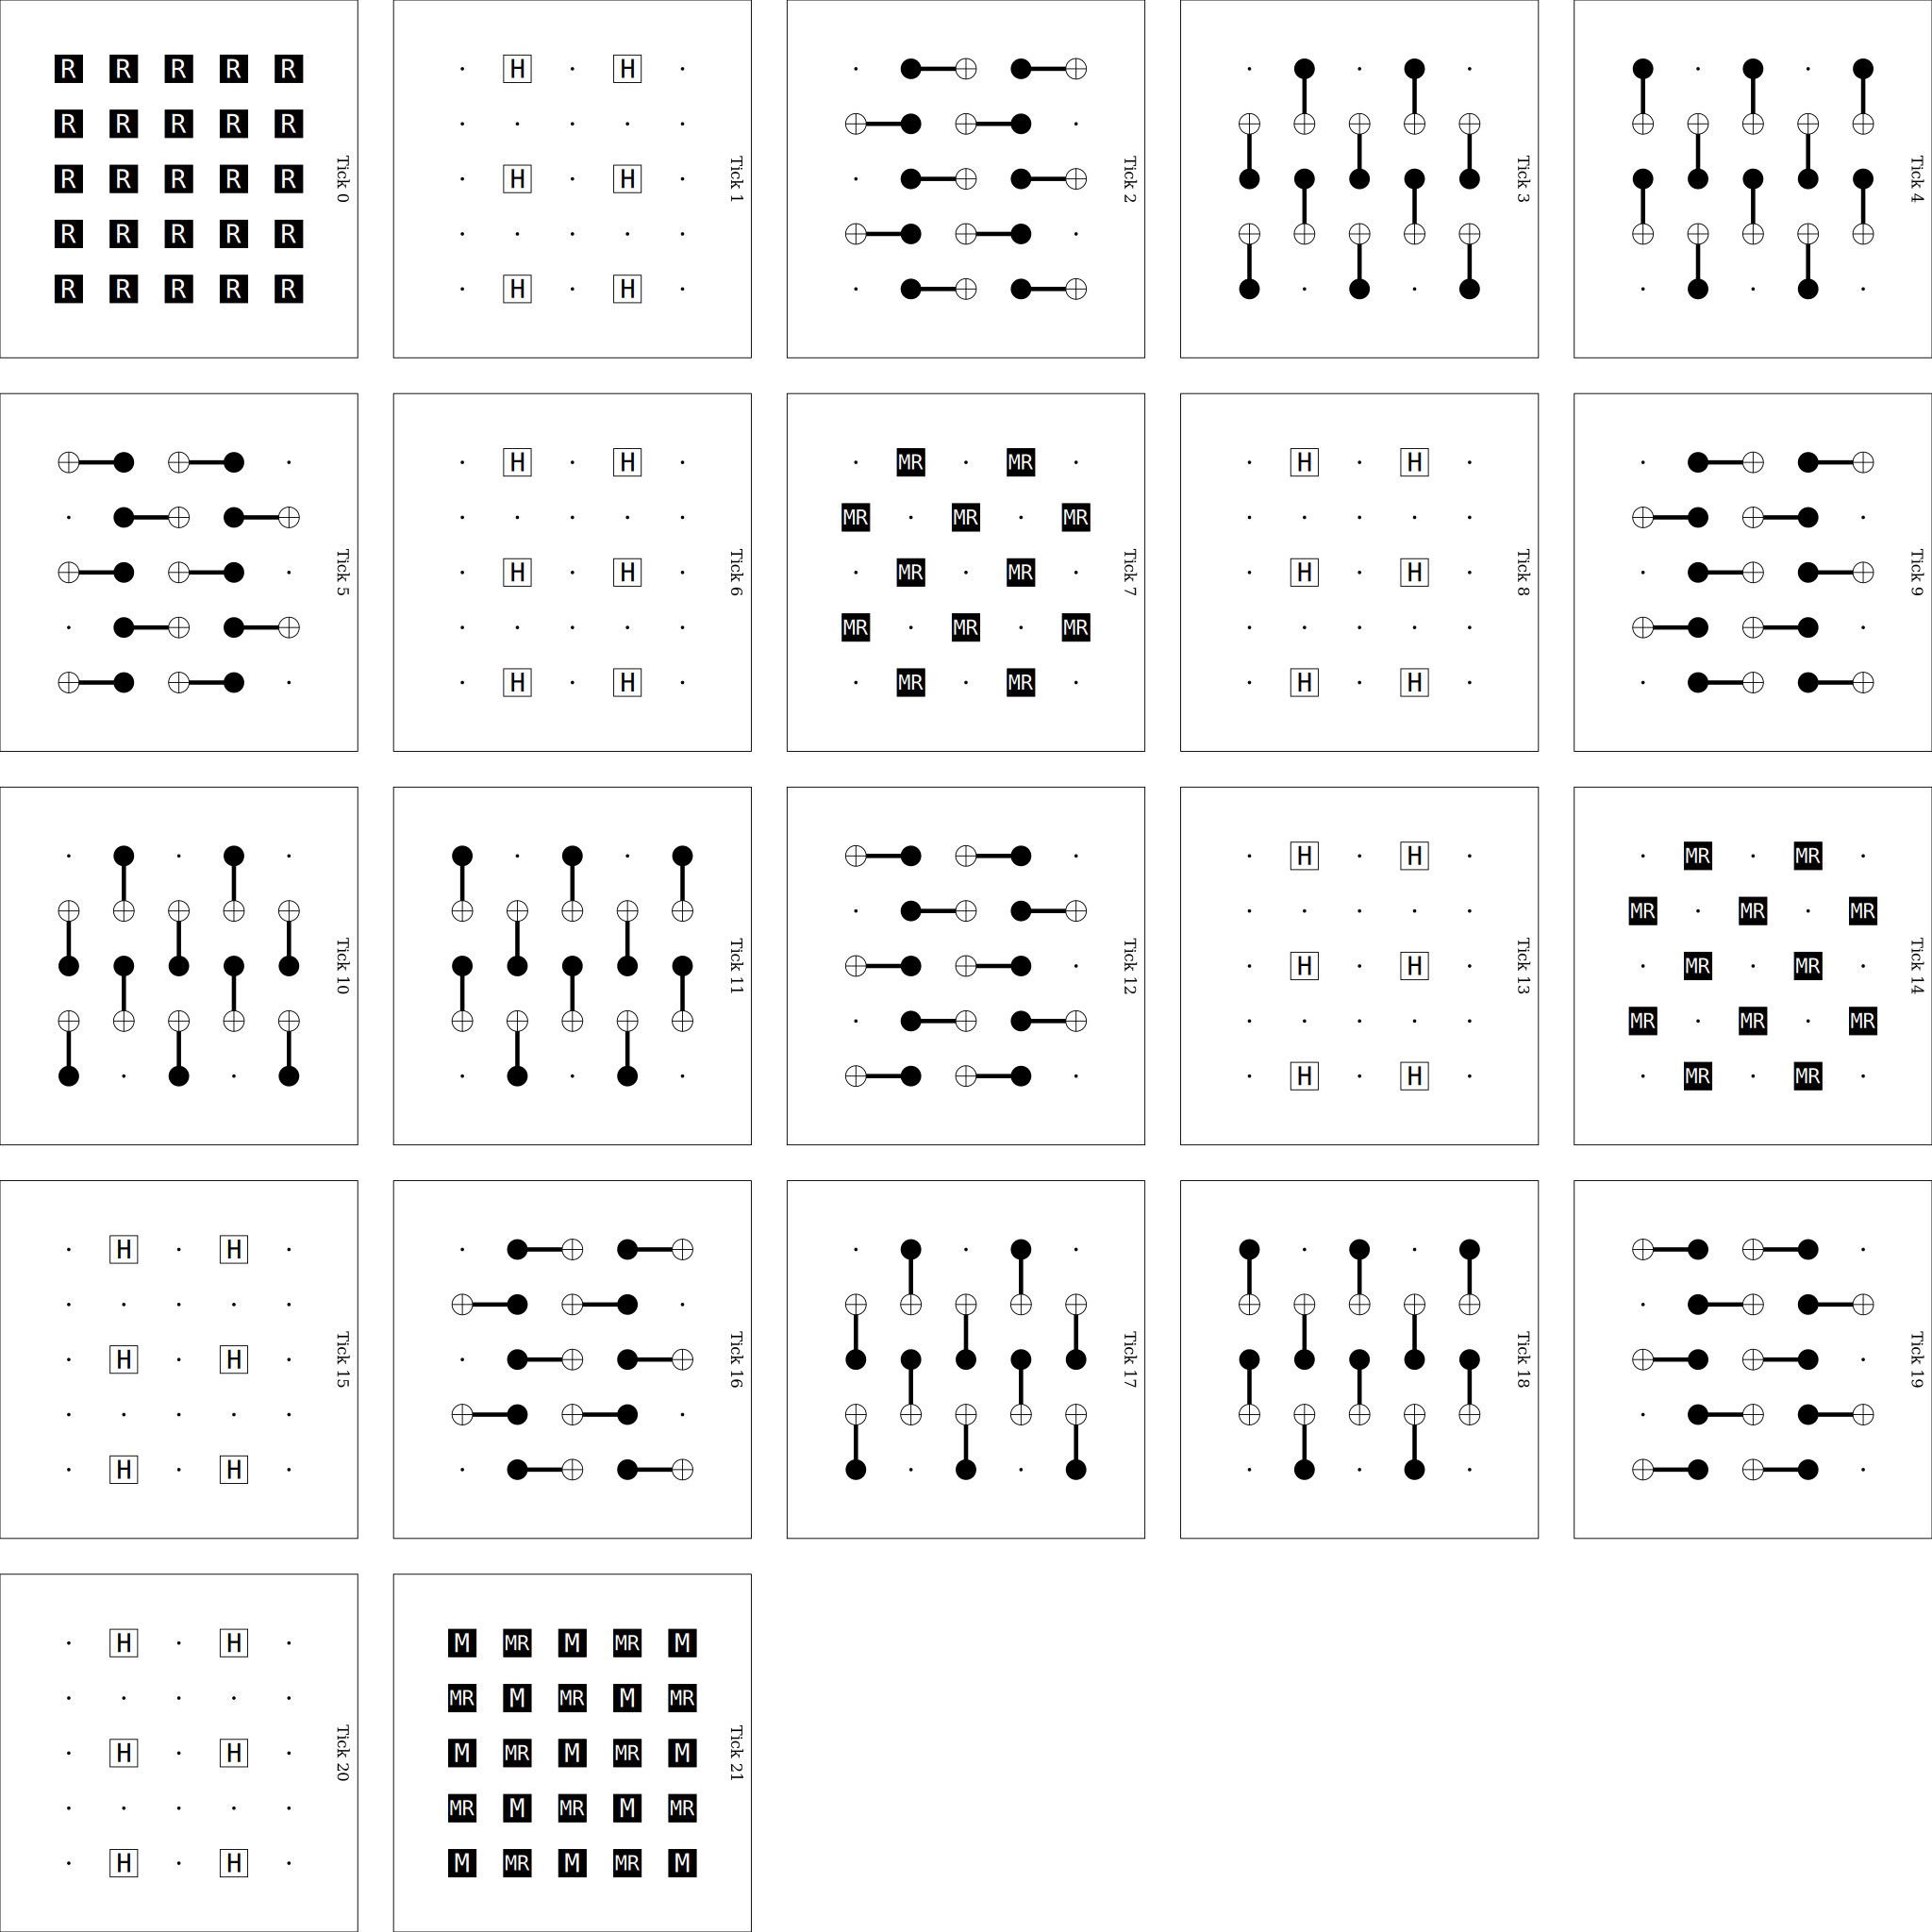

In [ ]:
sc.without_noise().diagram("timeline-3d")
sc.diagram("detslice-svg")

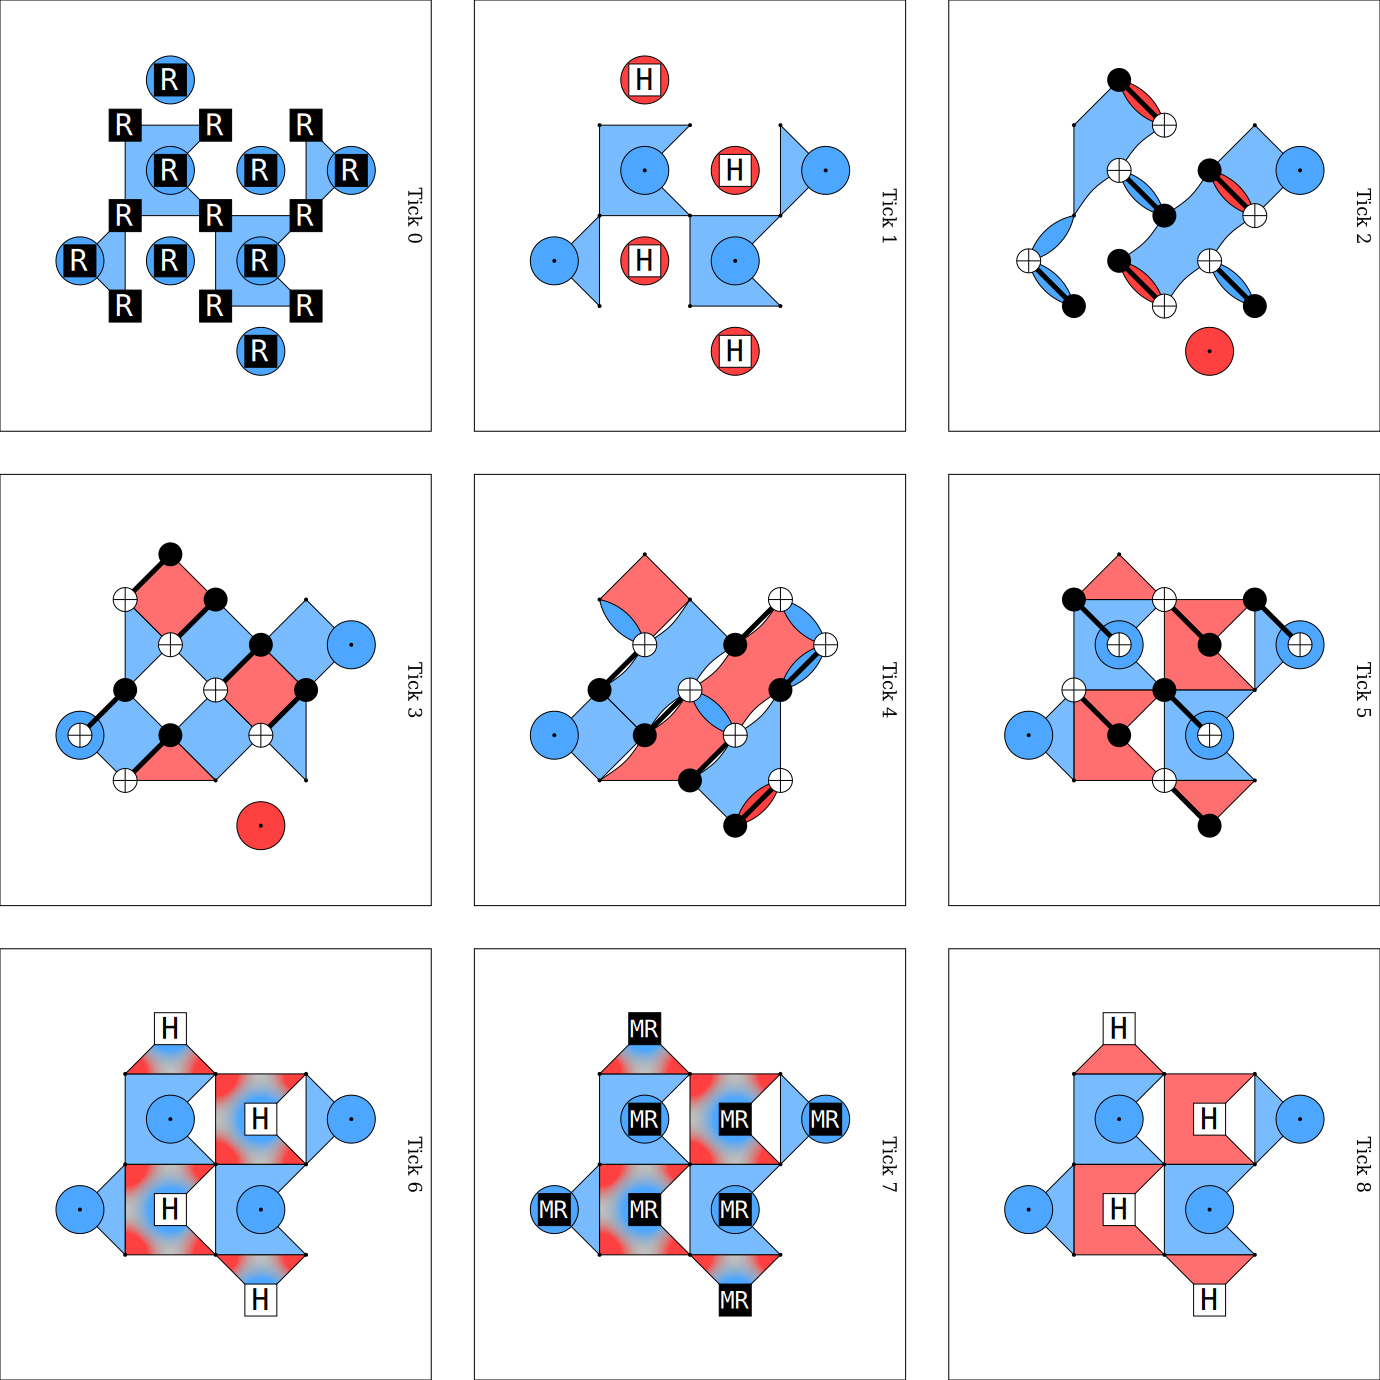

In [ ]:
sc.without_noise().diagram(
    "detslice-with-ops-svg",
    tick=range(0, 9),
)

In [ ]:
sc.diagram("matchgraph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"}],"materials":[{"doubleSided":true,"pbrMetallicRoughness":{"baseColorFactor":[0,0,0,1],"metallicFactor":1,"roughnessFactor":1}}],"meshes":[{"primitives":[{"attributes":{"POSITION":0},"material":0,"mode":6},{"attributes":{"POSITION":1},"material":0,"mode":6},{"attributes":{"POSITION":2},"material":0,"mode":6}]}],"nodes":[{"mesh":0,"translation":[0,12,0]},{"mesh":0,"translation":[6,6,0]},{"mesh":0,"translation":[12,12,0]},{"mesh":0,"translation":[18,6,0]},{"mesh":0,"translation":[6,0,3]},{"mesh":0,"translation":[6,6,3]},{"mesh":0,"translation":[12,6,3]},{"mesh":0,"translation":[18,6,3]},{"mesh":0,"translation":[0,12,3]},{"mesh":0,"translation":[6,12,3]},{"mesh":0,"translation":[12,12,3]},{"mesh":0,"translation":[12,18,3]},{"mesh":0,"translation":[0,12,6]},{"mesh":0,"translation":[6,6,6]},{"mesh":0,"translation":[12,12,6]},{"mesh":0,"translation":[18,6,6]}],"scene":0,"scenes":[{"nodes":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}]}

In [ ]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[False False]
 [False False]
 [ True  True]
 [False False]
 [False False]
 [False False]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]]


In [ ]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]]


In [ ]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)

0.319752
